# Preprocess
Before you can train a model on a dataset, it needs to be preprocessed into the expected model input format. Whether your data is text, images, or audio, they need to be converted and assembled into batches of tensors.

In this tutorial, you’ll learn that for:
* Text, use a **Tokenizer** to convert text into a sequence of tokens, create a numerical representation of the tokens, and assemble them into tensors.
* Image inputs use a **ImageProcessor** to convert images into tensors.
* Multimodal inputs, use a **Processor** to combine a tokenizer and a feature extractor or image processor.

> AutoProcessor always works and automatically chooses the correct class for the model you’re using, whether you’re using a tokenizer, image processor, feature extractor or processor.

## Natural Language Processing
The main tool for preprocessing textual data is a **tokenizer（分词器）**. A tokenizer splits text into tokens according to a set of rules. **The tokens are converted into numbers and then tensors, which become the model inputs.** Any additional inputs required by the model are added by the tokenizer.

Let us get start by loading a pretrained tokenizer with the AutoTokenizer.from_pretrained() method. This downloads the vocab a model was pretrained with:

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

Then pass your text to the tokenizer:

In [6]:
input_text = "Do not meddle in the affairs of wizards, for they are subtle and quick to anger."
encoded_input = tokenizer(input_text)
encoded_input

{'input_ids': [101, 2091, 1136, 1143, 13002, 1107, 1103, 5707, 1104, 16678, 1116, 117, 1111, 1152, 1132, 11515, 1105, 3613, 1106, 4470, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

The tokenizer returns a dictionary with three important items:
* **input_ids** are the indices corresponding to each token in the sentence.
* **attention_mask** indicates whether a token should be attended to or not.
* **token_type_ids** identifies which sequence a token belongs to when there is more than one sequence.

Return your input by decoding the input_ids:

In [7]:
tokenizer.decode(encoded_input["input_ids"])

'[CLS] Do not meddle in the affairs of wizards, for they are subtle and quick to anger. [SEP]'

As you can see, the tokenizer added two special tokens - <code>CLS</code> and <code>SEP</code> (classifier and separator) - to the sentence. Not all models need special tokens, but if they do, the tokenizer automatically adds them for you.

If there are several sentences you want to preprocess, pass them as a list to the tokenizer:

In [10]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_inputs = tokenizer(batch_sentences)
encoded_inputs

{'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}

### Pad
Sentences aren’t always the same length, which can be an issue because tensors, the model inputs, need to have a uniform shape. Padding is a strategy for ensuring tensors are rectangular by adding a special **padding token** to shorter sentences.

Set the padding parameter to True to pad the shorter sequences in the batch to match the longest sequence:

In [11]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True)
encoded_input

{'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102, 0, 0, 0, 0, 0, 0, 0], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}

The first and third sentences are now padded with 0’s because they are shorter.

### Truncation
On the other hand, sometimes a sequence may be too long for a model to handle. In this case, you’ll need to truncate the sequence to a shorter length.

Set the truncation parameter to True to truncate a sequence to the maximum length accepted by the model:

In [16]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True)
print(encoded_input, end='\n\n')
print('Maximum length for truncation, determined by the model:', tokenizer.model_max_length)

{'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102, 0, 0, 0, 0, 0, 0, 0], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}

Maximum length for truncation, determined by the model: 512


### Build tensors
Finally, you want the tokenizer to return the actual tensors that get fed to the model.

Set the return_tensors parameter to either pt for PyTorch, or tf for TensorFlow:

In [19]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
print(encoded_input['input_ids'], end='\n\n')
print(encoded_input['input_ids'].shape)

tensor([[  101,  1252,  1184,  1164,  1248,  6462,   136,   102,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1790,   112,   189,  1341,  1119,  3520,  1164,  1248,  6462,
           117, 21902,  1643,   119,   102],
        [  101,  1327,  1164,  5450, 23434,   136,   102,     0,     0,     0,
             0,     0,     0,     0,     0]])

torch.Size([3, 15])


## Computer vision
For computer vision tasks, you’ll need an **image processor** to prepare your dataset for the model.

Image preprocessing consists of several steps that convert images into the input expected by the model. These steps include but are not limited to **resizing, normalizing, color channel correction, and converting images to tensors**.

Load the food101 dataset to see how you can use an image processor with computer vision datasets.

> Use the split parameter to only load a small sample from the training split since the dataset is quite large.



In [22]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:100]")

Found cached dataset food101 (/home/zonghang/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


Next, take a look at the image:

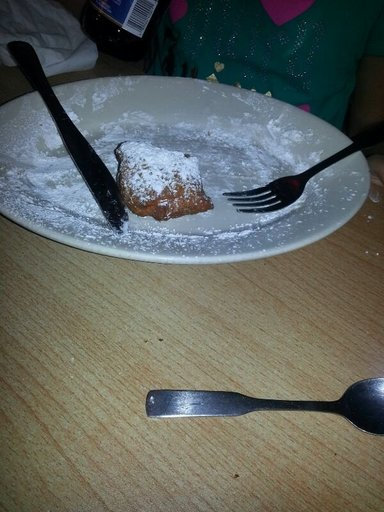

In [23]:
dataset[0]["image"]

Load the image processor with AutoImageProcessor.from_pretrained().

In [24]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

First, let’s add some **image augmentation**. 
1. Here we use <code>Compose</code> to chain together a couple of transforms - <code>RandomResizedCrop</code> and <code>ColorJitter</code>. Note that for resizing, we can get the image size requirements from the image_processor. For some models, an exact height and width are expected, for others only the shortest_edge is defined.

In [26]:
from torchvision.transforms import RandomResizedCrop, ColorJitter, Compose

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ColorJitter(brightness=0.5, hue=0.5)])

2. The model accepts pixel_values as its input. ImageProcessor can take care of **normalizing** the images, and generating appropriate **tensors**.

Create a function that combines image augmentation and image preprocessing for a batch of images and generates pixel_values:

In [27]:
def transforms(examples):
    images = [_transforms(img.convert("RGB")) for img in examples["image"]]
    examples["pixel_values"] = image_processor(images, do_resize=False, return_tensors="pt")["pixel_values"]
    return examples

> In the example above we set <code>do_resize=False</code> because we have already resized the images in the image augmentation transformation. If you do not resize images during image augmentation, leave this parameter out. By default, ImageProcessor will handle the resizing.

3. Then use set_transform to apply the transforms.

In [28]:
dataset.set_transform(transforms)

4. Now, when you access the image, you’ll notice the image processor has added pixel_values, and you can pass your processed dataset to the model now.

In [29]:
dataset[0].keys()

dict_keys(['image', 'label', 'pixel_values'])

Here is what the image looks like after the transforms are applied. The image has been randomly cropped and it’s color properties are different.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


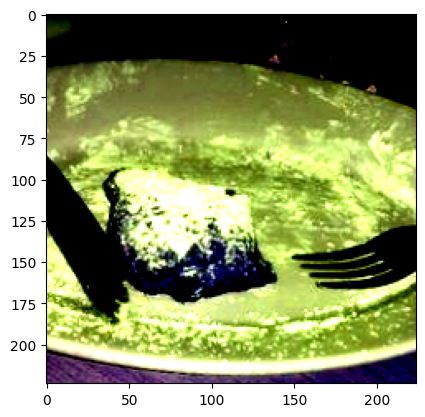

In [31]:
import numpy as np
import matplotlib.pyplot as plt

img = dataset[0]["pixel_values"]
plt.imshow(img.permute(1, 2, 0))